데이터 로딩 중...
  - OHLCV 데이터 로딩...
  - 포트폴리오 결과 파일들 로딩...
총 12개 분기 포트폴리오 로드됨
Data Leakage 방지: 분석 종료 다음날부터 투자 시작
  - 벤치마크 데이터 로딩...
캐시된 벤치마크 데이터를 로드합니다...
캐시에서 7066 행의 벤치마크 데이터를 로드했습니다.
데이터 로딩 완료!
Graham 포트폴리오 백테스팅 시작 (Data Leakage 방지)
백테스팅 기간: 2022-04-01 ~ 2025-03-31
*** Data Leakage 방지: 재무데이터 분석 후 다음날부터 투자 시작 ***

=== 리밸런싱 1: 2022-04-01 ===
투자 기간: 2022-04-01 ~ 2022-06-29
기간 종료 시 포트폴리오 가치: 0.7666

=== 리밸런싱 2: 2022-07-01 ===
투자 기간: 2022-07-01 ~ 2022-09-28
기간 종료 시 포트폴리오 가치: 0.7973

=== 리밸런싱 3: 2022-10-01 ===
투자 기간: 2022-10-01 ~ 2022-12-29
기간 종료 시 포트폴리오 가치: 0.8703

=== 리밸런싱 4: 2023-01-01 ===
투자 기간: 2023-01-01 ~ 2023-03-31
기간 종료 시 포트폴리오 가치: 1.0034

=== 리밸런싱 5: 2023-04-01 ===
투자 기간: 2023-04-01 ~ 2023-06-29
기간 종료 시 포트폴리오 가치: 1.1115

=== 리밸런싱 6: 2023-07-01 ===
투자 기간: 2023-07-01 ~ 2023-09-28
기간 종료 시 포트폴리오 가치: 1.0583

=== 리밸런싱 7: 2023-10-01 ===
투자 기간: 2023-10-01 ~ 2023-12-29
기간 종료 시 포트폴리오 가치: 1.2095

=== 리밸런싱 8: 2024-01-01 ===
투자 기간: 2024-01-01 ~ 2024-03-30
기간 종료 시 포트폴리오 가치: 1.3104

=== 리밸런싱 9: 20

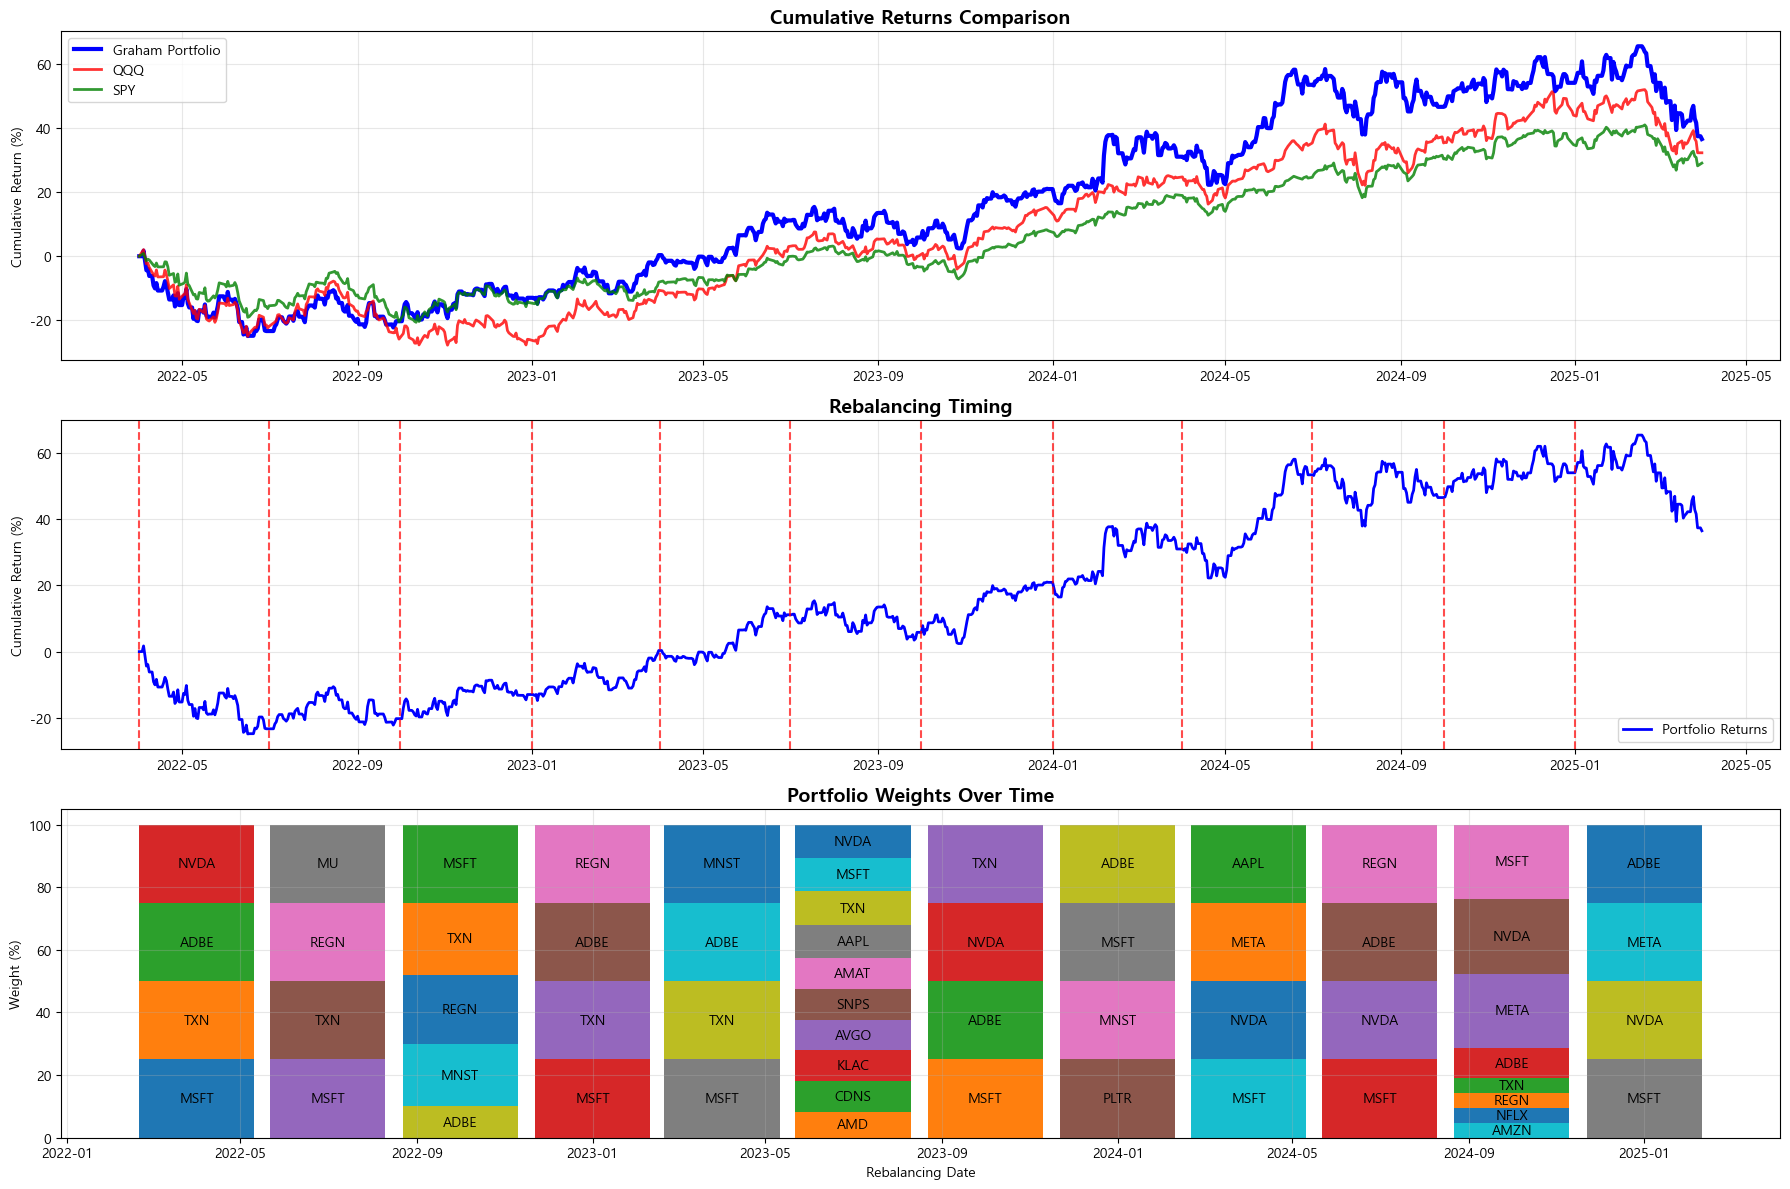

결과가 results/graham_agent\graham_backtest_results.xlsx에 저장되었습니다.


In [26]:
# 백테스팅 시스템 (Data Leakage 방지 + Yahoo Finance 캐싱)
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Yahoo Finance 데이터 가져오기

import yfinance as yf

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

class GrahamBacktester:
    """Graham 에이전트 포트폴리오 백테스팅 클래스 (Data Leakage 방지)"""
    
    def __init__(self, 
                 portfolio_dir="results/graham_agent", 
                 ohlcv_path="data/nasdaq100_ohlcv.csv",
                 benchmark_cache_path="data/benchmark_data.csv",
                 transaction_cost=0.0001):  # 0.01% 거래비용
        
        self.portfolio_dir = portfolio_dir
        self.ohlcv_path = ohlcv_path
        self.benchmark_cache_path = benchmark_cache_path
        self.transaction_cost = transaction_cost
        
        # 벤치마크 티커들 정의 (Yahoo Finance 심볼)
        self.benchmarks = {
            'QQQ': 'NASDAQ 100 ETF',
            'SPY': 'S&P 500 ETF'}
        
        # 데이터 로드
        self.load_data()
        
        # 백테스팅 결과 저장용
        self.backtest_results = {}
        
    def download_and_cache_benchmark_data(self, start_date='2020-01-01', end_date=None):
        """Yahoo Finance에서 벤치마크 데이터를 다운로드하고 캐시에 저장"""
        
        if end_date is None:
            end_date = datetime.now().strftime('%Y-%m-%d')
            
        print("벤치마크 데이터 다운로드 및 캐싱 중...")
        
        all_benchmark_data = []
        
        for ticker in self.benchmarks.keys():
            try:
                print(f"  - {ticker} ({self.benchmarks[ticker]}) 다운로드 중...")
                
                # Yahoo Finance에서 데이터 가져오기
                data = yf.download(ticker, start=start_date, end=end_date, progress=False)
                
                if data.empty:
                    print(f"    경고: {ticker} 데이터를 가져올 수 없습니다.")
                    continue
                    
                # 데이터 정리
                data = data.reset_index()
                data['ticker'] = ticker
                data['date'] = pd.to_datetime(data['Date'])
                
                # 조정주가 우선, 없으면 종가 사용
                data['price'] = data['Adj Close'] if 'Adj Close' in data.columns else data['Close']
                
                # 필요한 열만 선택
                clean_data = data[['ticker', 'date', 'price']].copy()
                all_benchmark_data.append(clean_data)
                
                print(f"    {ticker}: {len(clean_data)}개 데이터 포인트 다운로드 완료")
                
            except Exception as e:
                print(f"    오류: {ticker} 다운로드 실패 - {e}")
                continue
        
        if all_benchmark_data:
            # 모든 벤치마크 데이터 결합
            combined_data = pd.concat(all_benchmark_data, ignore_index=True)
            
            # 캐시 파일로 저장
            os.makedirs(os.path.dirname(self.benchmark_cache_path), exist_ok=True)
            combined_data.to_csv(self.benchmark_cache_path, index=False)
            
            print(f"벤치마크 데이터가 {self.benchmark_cache_path}에 저장되었습니다.")
            print(f"총 {len(combined_data)} 행의 데이터가 저장되었습니다.")
            
            return combined_data
        else:
            print("다운로드된 벤치마크 데이터가 없습니다.")
            return None
            
    def load_benchmark_data(self, force_download=False):
        """캐시된 벤치마크 데이터 로드 또는 다운로드"""
        
        # 강제 다운로드이거나 캐시 파일이 없으면 다운로드
        if force_download or not os.path.exists(self.benchmark_cache_path):
            print("벤치마크 데이터를 새로 다운로드합니다...")
            return self.download_and_cache_benchmark_data()
        
        try:
            # 캐시된 데이터 로드
            print("캐시된 벤치마크 데이터를 로드합니다...")
            benchmark_data = pd.read_csv(self.benchmark_cache_path)
            benchmark_data['date'] = pd.to_datetime(benchmark_data['date'])
            
            print(f"캐시에서 {len(benchmark_data)} 행의 벤치마크 데이터를 로드했습니다.")
            
            # 데이터가 최신인지 확인 (마지막 날짜가 1주일 이상 오래되었으면 업데이트)
            latest_date = benchmark_data['date'].max()
            if (datetime.now() - latest_date).days > 7:
                print("벤치마크 데이터가 오래되었습니다. 업데이트 중...")
                return self.download_and_cache_benchmark_data()
            
            return benchmark_data
            
        except Exception as e:
            print(f"캐시 로드 실패: {e}")
            print("벤치마크 데이터를 새로 다운로드합니다...")
            return self.download_and_cache_benchmark_data()
        
    def load_data(self):
        """필요한 데이터들을 로드"""
        print("데이터 로딩 중...")
        
        # OHLCV 데이터 로드
        print("  - OHLCV 데이터 로딩...")
        self.ohlcv_df = pd.read_csv(self.ohlcv_path)
        self.ohlcv_df['EVAL_D'] = pd.to_datetime(self.ohlcv_df['EVAL_D'])
        
        # 포트폴리오 파일들 로드
        print("  - 포트폴리오 결과 파일들 로딩...")
        self.load_portfolio_files()
        
        # 벤치마크 데이터 로드
        print("  - 벤치마크 데이터 로딩...")
        self.benchmark_df = self.load_benchmark_data()
        
        print("데이터 로딩 완료!")
        
    def load_portfolio_files(self):
        """포트폴리오 CSV 파일들을 로드하여 시계열 데이터로 구성"""
        portfolio_files = glob.glob(f"{self.portfolio_dir}/graham_portfolio_*.csv")
        
        self.portfolios = []
        
        for file in sorted(portfolio_files):
            try:
                # 파일명에서 날짜 추출
                filename = os.path.basename(file)
                date_part = filename.replace('graham_portfolio_', '').replace('.csv', '')
                start_date, end_date = date_part.split('_')
                
                # CSV 파일 로드
                df = pd.read_csv(file)
                if len(df) == 0 or (len(df) == 1 and df.iloc[0].isnull().all()):
                    continue
                    
                # 빈 행 제거
                df = df.dropna(subset=['Ticker'])

                # Weight (%) 컬럼 다 더했을 때 100이 아니면, 비율 맞춰서 다시 조정
                if sum(df['Weight (%)']) != 100:
                    df['Weight (%)'] = df['Weight (%)'] / sum(df['Weight (%)']) * 100
                
                if len(df) > 0:
                    df['analysis_start'] = pd.to_datetime(start_date)  # 분석 시작일
                    df['analysis_end'] = pd.to_datetime(end_date)      # 분석 종료일
                    
                    # *** DATA LEAKAGE 방지: 분석 종료일 이후부터 투자 시작 ***
                    df['investment_start'] = df['analysis_end'] + timedelta(days=1)
                    
                    # 다음 분기 시작일 계산 (대략 3개월 후)
                    next_quarter_start = df['analysis_end'] + timedelta(days=90)
                    df['investment_end'] = next_quarter_start
                    
                    self.portfolios.append(df)
                    
            except Exception as e:
                print(f"파일 로딩 실패: {file}, 오류: {e}")
                
        if self.portfolios:
            self.portfolio_timeline = pd.concat(self.portfolios, ignore_index=True)
            print(f"총 {len(self.portfolios)}개 분기 포트폴리오 로드됨")
            print("Data Leakage 방지: 분석 종료 다음날부터 투자 시작")
        else:
            print("로드된 포트폴리오가 없습니다!")
            
    def get_price_data(self, ticker, start_date, end_date):
        """특정 기간의 주가 데이터 조회 (로컬 데이터 우선)"""
        ticker_data = self.ohlcv_df[
            (self.ohlcv_df['TICKERSYMBOL'] == ticker) &
            (self.ohlcv_df['EVAL_D'] >= start_date) &
            (self.ohlcv_df['EVAL_D'] <= end_date)
        ].copy()
        
        if len(ticker_data) == 0:
            return None
            
        # 조정주가 우선, 없으면 종가 사용
        ticker_data['price'] = ticker_data['DIV_ADJ_CLOSE'].fillna(ticker_data['CLOSE_'])
        
        return ticker_data[['EVAL_D', 'price']].sort_values('EVAL_D')
        
    def get_benchmark_data(self, ticker, start_date, end_date):
        """캐시된 벤치마크 데이터에서 특정 기간 조회"""
        if self.benchmark_df is None:
            return None
            
        ticker_data = self.benchmark_df[
            (self.benchmark_df['ticker'] == ticker) &
            (self.benchmark_df['date'] >= start_date) &
            (self.benchmark_df['date'] <= end_date)
        ].copy()
        
        if len(ticker_data) == 0:
            return None
            
        return ticker_data[['date', 'price']].sort_values('date')
        
    def calculate_turnover_and_costs(self, current_weights, target_weights):
        """포트폴리오 회전율과 거래비용 계산"""
        # 현재 가중치와 목표 가중치의 차이
        weight_changes = {}
        
        all_tickers = set(list(current_weights.keys()) + list(target_weights.keys()))
        
        total_turnover = 0.0
        for ticker in all_tickers:
            current_w = current_weights.get(ticker, 0.0)
            target_w = target_weights.get(ticker, 0.0)
            change = abs(target_w - current_w)
            total_turnover += change
            weight_changes[ticker] = target_w - current_w
            
        # 회전율 = 총 가중치 변화량의 절반 (buy + sell = 2 * actual_turnover)
        turnover = total_turnover / 2.0
        
        # 거래비용 = 회전율 × 거래비용률
        transaction_costs = turnover * self.transaction_cost
        
        return turnover, transaction_costs, weight_changes
        
    def calculate_portfolio_returns(self, start_date=None, end_date=None):
        """개선된 포트폴리오 수익률 계산 (Data Leakage 방지)"""
        if start_date is None:
            start_date = self.portfolio_timeline['investment_start'].min()
        if end_date is None:
            end_date = self.portfolio_timeline['investment_end'].max()
            
        print(f"백테스팅 기간: {start_date.strftime('%Y-%m-%d')} ~ {end_date.strftime('%Y-%m-%d')}")
        print("*** Data Leakage 방지: 재무데이터 분석 후 다음날부터 투자 시작 ***")
        
        # 리밸런싱 날짜 찾기
        rebalance_dates = sorted(self.portfolio_timeline['investment_start'].unique())
        
        # 전체 결과를 저장할 리스트
        all_results = []
        
        # 포트폴리오 초기 가치 (1.0으로 시작)
        current_portfolio_value = 1.0
        
        for i, rebalance_date in enumerate(rebalance_dates):
            print(f"\n=== 리밸런싱 {i+1}: {rebalance_date.strftime('%Y-%m-%d')} ===")
            
            # 해당 기간의 포트폴리오 구성
            period_portfolio = self.portfolio_timeline[
                self.portfolio_timeline['investment_start'] == rebalance_date
            ]
            
            period_start = period_portfolio['investment_start'].iloc[0]
            period_end = period_portfolio['investment_end'].iloc[0]
            
            print(f"투자 기간: {period_start.strftime('%Y-%m-%d')} ~ {period_end.strftime('%Y-%m-%d')}")
            
            # 해당 기간의 주가 데이터 수집
            period_data = {}
            weights = {}
            
            for _, stock in period_portfolio.iterrows():
                ticker = stock['Ticker']
                weight = float(stock['Weight (%)']) / 100.0
                weights[ticker] = weight
                
                # 주가 데이터 조회
                ticker_data = self.ohlcv_df[
                    (self.ohlcv_df['TICKERSYMBOL'] == ticker) &
                    (self.ohlcv_df['EVAL_D'] >= period_start) &
                    (self.ohlcv_df['EVAL_D'] <= period_end)
                ].copy()
                
                if len(ticker_data) == 0:
                    print(f"경고: {ticker}에 대한 데이터가 없습니다.")
                    continue
                
                # 컬럼명 확인
                close_columns = [col for col in ticker_data.columns if 'CLOSE' in col.upper()]
                if not close_columns:
                    print(f"경고: {ticker}에 대한 종가 컬럼을 찾을 수 없습니다.")
                    continue
                
                close_col = close_columns[0]
                period_data[ticker] = ticker_data[['EVAL_D', close_col]].copy()
                period_data[ticker].rename(columns={close_col: 'price'}, inplace=True)
            
            if not period_data:
                print("이 기간에 유효한 데이터가 없습니다.")
                continue
            
            # 모든 종목의 날짜를 통합
            all_dates = set()
            for ticker_data in period_data.values():
                all_dates.update(ticker_data['EVAL_D'].tolist())
            all_dates = sorted(all_dates)
            
            # 기간 시작 시점의 가격으로 정규화 (리밸런싱 기준점)
            start_prices = {}
            for ticker, ticker_data in period_data.items():
                start_price_data = ticker_data[ticker_data['EVAL_D'] == period_start]
                if len(start_price_data) > 0:
                    start_prices[ticker] = start_price_data['price'].iloc[0]
                else:
                    # 가장 가까운 과거 데이터 사용
                    valid_data = ticker_data[ticker_data['EVAL_D'] <= period_start]
                    if len(valid_data) > 0:
                        start_prices[ticker] = valid_data['price'].iloc[-1]
                    else:
                        start_prices[ticker] = ticker_data['price'].iloc[0]
            
            # 각 날짜별 포트폴리오 가치 계산
            period_results = []
            
            for date in all_dates:
                portfolio_value = 0.0
                valid_stocks = 0
                
                for ticker, weight in weights.items():
                    if ticker not in period_data or ticker not in start_prices:
                        continue
                    
                    # 해당 날짜의 가격 조회 (없으면 가장 최근 가격)
                    ticker_data = period_data[ticker]
                    price_data = ticker_data[ticker_data['EVAL_D'] <= date]
                    
                    if len(price_data) > 0:
                        current_price = price_data['price'].iloc[-1]
                        start_price = start_prices[ticker]
                        
                        # 개별 종목 수익률 * 가중치
                        stock_return = (current_price / start_price) if start_price != 0 else 1.0
                        portfolio_value += stock_return * weight
                        valid_stocks += 1
                
                if valid_stocks > 0:
                    period_results.append({
                        'date': date,
                        'period_return': portfolio_value,  # 이 기간 내 수익률
                        'period': i + 1
                    })
            
            # 기간별 결과를 전체 포트폴리오 가치에 연결
            if period_results:
                # 이전 기간 마지막 가치에서 시작
                period_start_value = current_portfolio_value
                
                for result in period_results:
                    # 현재 기간의 수익률을 이전 가치에 적용
                    result['cumulative_value'] = period_start_value * result['period_return']
                    all_results.append(result)
                
                # 다음 기간을 위해 현재 가치 업데이트
                current_portfolio_value = period_results[-1]['cumulative_value']
                
                print(f"기간 종료 시 포트폴리오 가치: {current_portfolio_value:.4f}")
        
        if not all_results:
            return pd.DataFrame()
        
        # 최종 DataFrame 생성
        final_df = pd.DataFrame(all_results)
        final_df = final_df.sort_values('date').reset_index(drop=True)
        
        # 수익률 지표 계산
        final_df['normalized_value'] = final_df['cumulative_value']
        final_df['daily_return'] = final_df['normalized_value'].pct_change()
        final_df['cumulative_return'] = (final_df['normalized_value'] - 1) * 100
        
        # 필요한 컬럼만 선택
        result_df = final_df[['date', 'normalized_value', 'daily_return', 'cumulative_return']].copy()
        # result_df.rename(columns={'normalized_value': 'price'}, inplace=True)
        
        print(f"\n총 {len(result_df)}개 데이터 포인트 생성")
        print(f"최종 누적 수익률: {result_df['cumulative_return'].iloc[-1]:.2f}%")
        
        return result_df

        
    def calculate_benchmark_returns(self, start_date, end_date, benchmark_tickers=None):
        """캐시된 벤치마크 데이터에서 수익률 계산"""
        if benchmark_tickers is None:
            benchmark_tickers = list(self.benchmarks.keys())
            
        benchmark_results = {}
        
        for ticker in benchmark_tickers:
            benchmark_data = self.get_benchmark_data(ticker, start_date, end_date)
            
            if benchmark_data is None or len(benchmark_data) == 0:
                print(f"벤치마크 데이터 없음: {ticker}")
                continue
                
            # 수익률 계산
            benchmark_data['normalized_value'] = benchmark_data['price'] / benchmark_data['price'].iloc[0]
            benchmark_data['daily_return'] = benchmark_data['normalized_value'].pct_change()
            benchmark_data['cumulative_return'] = (benchmark_data['normalized_value'] - 1) * 100
            
            benchmark_results[ticker] = benchmark_data
            
        return benchmark_results
        
    def calculate_performance_metrics(self, returns_df):
        """성과 지표 계산"""
        if returns_df is None or len(returns_df) == 0:
            return {}
            
        daily_returns = returns_df['daily_return'].dropna()
        
        if len(daily_returns) == 0:
            return {}
            
        metrics = {}
        
        # 기본 수익률 지표
        metrics['총 수익률 (%)'] = returns_df['cumulative_return'].iloc[-1]
        metrics['연환산 수익률 (%)'] = ((returns_df['normalized_value'].iloc[-1] ** (252 / len(returns_df))) - 1) * 100
        
        # 리스크 지표
        metrics['변동성 (%)'] = daily_returns.std() * np.sqrt(252) * 100
        metrics['샤프 비율'] = (metrics['연환산 수익률 (%)'] / metrics['변동성 (%)']) if metrics['변동성 (%)'] != 0 else 0
        
        # 최대 낙폭 (Max Drawdown)
        running_max = returns_df['normalized_value'].expanding().max()
        drawdown = (returns_df['normalized_value'] - running_max) / running_max
        metrics['최대 낙폭 (%)'] = drawdown.min() * 100
        
        # 승률
        positive_days = (daily_returns > 0).sum()
        total_days = len(daily_returns)
        metrics['승률 (%)'] = (positive_days / total_days) * 100 if total_days > 0 else 0
        
        return metrics
        
    def run_backtest(self, start_date=None, end_date=None, force_download_benchmarks=False):
        """전체 백테스팅 실행"""
        print("=" * 80)
        print("Graham 포트폴리오 백테스팅 시작 (Data Leakage 방지)")
        print("=" * 80)
        
        # 벤치마크 데이터 강제 다운로드 옵션
        if force_download_benchmarks:
            print("벤치마크 데이터를 강제로 새로 다운로드합니다...")
            self.benchmark_df = self.load_benchmark_data(force_download=True)
        
        # 포트폴리오 수익률 계산
        portfolio_returns = self.calculate_portfolio_returns(start_date, end_date)
        
        if len(portfolio_returns) == 0:
            print("포트폴리오 데이터가 없습니다!")
            return None
            
        # 실제 데이터 기간으로 조정
        actual_start = portfolio_returns['date'].min()
        actual_end = portfolio_returns['date'].max()
        
        # 벤치마크 수익률 계산
        benchmark_results = self.calculate_benchmark_returns(actual_start, actual_end)
        
        # 성과 지표 계산
        portfolio_metrics = self.calculate_performance_metrics(portfolio_returns)
        
        benchmark_metrics = {}
        for ticker, data in benchmark_results.items():
            benchmark_metrics[ticker] = self.calculate_performance_metrics(data)
        
        # 결과 저장
        self.backtest_results = {
            'portfolio_returns': portfolio_returns,
            'benchmark_results': benchmark_results,
            'portfolio_metrics': portfolio_metrics,
            'benchmark_metrics': benchmark_metrics,
            'start_date': actual_start,
            'end_date': actual_end
        }
        
        return self.backtest_results
        
                
    def plot_performance(self, figsize=(18, 12)):
        """Performance chart plotting"""
        if not self.backtest_results:
            print("Please run backtest first!")
            return
            
        portfolio_returns = self.backtest_results['portfolio_returns']
        benchmark_results = self.backtest_results['benchmark_results']
        
        fig, axes = plt.subplots(3, 1, figsize=figsize)
        
        # 1. Cumulative returns comparison
        ax1 = axes[0]
        ax1.plot(portfolio_returns['date'], portfolio_returns['cumulative_return'], 
                label='Graham Portfolio', linewidth=3, color='blue')
        
        colors = ['red', 'green', 'orange', 'purple', 'brown']
        for i, (ticker, data) in enumerate(benchmark_results.items()):
            if data is not None:
                ax1.plot(data['date'], data['cumulative_return'], 
                        label=f'{ticker}', 
                        linewidth=2, color=colors[i % len(colors)], alpha=0.8)
                        
        ax1.set_title('Cumulative Returns Comparison', fontsize=14, fontweight='bold')
        ax1.set_ylabel('Cumulative Return (%)')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # 2. Rebalancing timing display
        ax2 = axes[1]
        
        # Portfolio rebalancing dates display
        rebalance_dates = []
        for _, portfolio in self.portfolio_timeline.iterrows():
            rebalance_dates.append(portfolio['investment_start'])
            
        rebalance_dates = sorted(set(rebalance_dates))
        
        ax2.plot(portfolio_returns['date'], portfolio_returns['cumulative_return'], 
                label='Portfolio Returns', linewidth=2, color='blue')
        
        for date in rebalance_dates:
            if date >= portfolio_returns['date'].min() and date <= portfolio_returns['date'].max():
                ax2.axvline(x=date, color='red', linestyle='--', alpha=0.7)
                
        ax2.set_title('Rebalancing Timing', fontsize=14, fontweight='bold')
        ax2.set_ylabel('Cumulative Return (%)')
        ax2.legend()
        ax2.grid(True, alpha=0.3)

        # 3. visualize portfolio weights in each rebalancing date
        ax3 = axes[2]

        rebalance_dates = self.portfolio_timeline['investment_start'].unique()
        rebalance_dates = sorted(rebalance_dates)

        # 각 리밸런싱 날짜별로 처리
        for i, date in enumerate(rebalance_dates):
            df = self.portfolio_timeline[self.portfolio_timeline['investment_start'] == date]
            df = df[['Ticker', 'Weight (%)']]
            df = df.sort_values('Weight (%)', ascending=True)  # 아래에서부터 쌓기 위해 오름차순

            print(f"리밸런싱 날짜: {date}")
            print(sum(df['Weight (%)']))
            
            bottom = 0
            for _, row in df.iterrows():
                # 각 종목별 막대 그리기
                ax3.bar(date, row['Weight (%)'], bottom=bottom, width=80)
                
                # 각 구간의 중앙에 티커 표시
                if row['Weight (%)'] > 0:
                    ax3.text(date, bottom + row['Weight (%)']/2, row['Ticker'],
                            ha='center', va='center')
                bottom += row['Weight (%)']

        ax3.set_title('Portfolio Weights Over Time', fontsize=14, fontweight='bold')
        ax3.set_ylabel('Weight (%)')
        ax3.set_xlabel('Rebalancing Date')
        ax3.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()
        
    def save_results(self, filename="graham_backtest_results.xlsx"):
        """백테스팅 결과를 엑셀 파일로 저장"""
        if not self.backtest_results:
            print("저장할 결과가 없습니다!")
            return
        
        # portfolio_dir 이 경로에다가 저장해주기
        filename = os.path.join(self.portfolio_dir, filename)
            
        with pd.ExcelWriter(filename, engine='openpyxl') as writer:
            # 포트폴리오 수익률
            self.backtest_results['portfolio_returns'].to_excel(
                writer, sheet_name='Portfolio_Returns', index=False
            )
            
            # 벤치마크 수익률들
            for ticker, data in self.backtest_results['benchmark_results'].items():
                if data is not None:
                    data.to_excel(writer, sheet_name=f'Benchmark_{ticker}', index=False)
            
            # 성과 지표 비교
            all_metrics = {'Graham_Portfolio': self.backtest_results['portfolio_metrics']}
            all_metrics.update(self.backtest_results['benchmark_metrics'])
            
            metrics_df = pd.DataFrame(all_metrics).T
            metrics_df.to_excel(writer, sheet_name='Performance_Comparison')
            
            # 포트폴리오 구성 히스토리 (투자 일정 포함)
            if hasattr(self, 'portfolio_timeline'):
                self.portfolio_timeline.to_excel(
                    writer, sheet_name='Portfolio_History', index=False
                )
        
        print(f"결과가 {filename}에 저장되었습니다.")

# 사용 예시
if __name__ == "__main__":
    # 백테스터 초기화 (거래비용 0.01%)
    backtester = GrahamBacktester(transaction_cost=0.0001)
    
    # 백테스팅 실행
    results = backtester.run_backtest()
    
    # 차트 그리기
    backtester.plot_performance()
    
    # 결과 저장
    backtester.save_results()